# Biostat M280 Homework 3

**Due Friday, May 25 @ 11:59PM**

## Q1 - Big $n$ regression

Those who took my _203B: Introduction to Data Science_ last quarter had a (painful) experience of wrangling an Apache Spark cluster to do linear regression on a dataset with more than 100 million observations. Now we learnt various methods for solving linear regression and should realize that, with right choice of algorithm, it is a problem that can be handled by any moderate computer.

### Q1(1)

Download the flight data from <http://stat-computing.org/dataexpo/2009/the-data.html>. For this exercise, we only need data from years 2003-2008. If you are using Mac or Linux, you can run the following Bash script, which downloads and unzips files for all years.
```bash
# Download flight data by year
for i in {1987..2008}
  do
    echo "$(date) $i Download"
    fnam=$i.csv.bz2
    wget -O ./$fnam http://stat-computing.org/dataexpo/2009/$fnam
    echo "$(date) $i unzip"
    bzip2 -d ./$fnam
  done

# Download airline carrier data
wget -O ./airlines.csv http://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS

# Download airports data
wget -O ./airports.csv https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
```
Find out how many data points in each year.

In [1]:
# how many data points
for i in 2003:2008
    file = "$i.csv"
    @show i
    @show countlines(file)
end

i = 2003
countlines(file) = 6488541
i = 2004
countlines(file) = 7129271
i = 2005
countlines(file) = 7140597
i = 2006
countlines(file) = 7141923
i = 2007
countlines(file) = 7453216
i = 2008
countlines(file) = 7009729


### Q1(2) 

We are interested in how the time gain of a flight, defined as `DepDelay - ArrDelay`, depends on the distance traveled (`Distance`), departure delay (`DepDelay`), and carrier (`UniqueCarrier`). 

We want to fit a linear regression `Gain ~ 1 + Distance + DepDelay + UniqueCarrier` using data from 2003-2008. Note `UniqueCarrier` is a factor with 23 levels: "9E", "AA", "AQ", "AS", "B6", "CO", "DH", "DL", "EV", "F9", "FL", "HA", "HP", "MQ", "NW", "OH", "OO", "TZ", "UA", "US", "WN", "XE", and "YV". We use the dummy coding with "9E" as base level.

Will the design matrix (in double precision) fit into the memory of you computer?

#### Q1(2) Answer:

One year's data have about 7M rows, so the number of rows from 2003 to 2008 are about 42M. By using double precision (8 Bytes) for the matrix $\mathbf{X}$ which has 25 columns, it would occupy at least $42\text{M} \times 8\text{B} \times 25 = 8.4\text{GB}$ which is larger than my computer's 8G memory. Therefore, appending all the data to a giant matrix to do regression is not feasible for my computer.

### Q1(3)

Review the [Summary of Linear Regression](http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/12-linreg/linreg.html) and devise a strategy to solve the linear regression.

Report the estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors.

Hint: It took my laptop less than 3 minutes to import data and fit linear regression.

#### Q1(3) Answer: 

The key of using OLS (Prdinary Least Squares) to estimate linear regression parameters is to compute $\mathbf{X}^T\mathbf{X}$ and $\mathbf{X}^T\mathbf{y}$. Instead of building a giant $\mathbf{X}$ with 42M of rows and then computing, we can partition $\mathbf{X}$ and $\mathbf{y}$ to blocks each corresponding the data from a single year's data. Formally, if there are $k$ years' data:

$$ \mathbf{X} =\begin{bmatrix}
    \mathbf{x_{1}} \\
    \mathbf{x_{2}} \\
    ... \\
    \mathbf{x_{k}} \\
\end{bmatrix}      \quad     \mathbf{y} = \begin{bmatrix}
    \mathbf{y_{1}} \\
    \mathbf{y_{2}} \\
    ... \\
    \mathbf{y_{k}} \\
\end{bmatrix} 
$$

$$ \mathbf{X}^T\mathbf{X} = \begin{bmatrix}
    \mathbf{x_{1}} & \mathbf{x_{2}} & ... & \mathbf{x_{k}}
\end{bmatrix} \begin{bmatrix}
    \mathbf{x_{1}} \\
    \mathbf{x_{2}} \\
    ... \\
    \mathbf{x_{k}} \\
\end{bmatrix} = \sum^k_{i=1}{\mathbf{x_{i}}^T\mathbf{x_{i}}}  
$$

$$
\mathbf{X}^T\mathbf{y} = \begin{bmatrix}
    \mathbf{x_{1}} & \mathbf{x_{2}} & ... & \mathbf{x_{k}}
\end{bmatrix} \begin{bmatrix}
    \mathbf{y_{1}} \\
    \mathbf{y_{2}} \\
    ... \\
    \mathbf{y_{k}} \\
\end{bmatrix} = \sum^k_{i=1}{\mathbf{x_{i}}^T\mathbf{y_{i}}} $$

$$
\mathbf{y}^T\mathbf{y} = \begin{bmatrix}
    \mathbf{y_{1}} & \mathbf{y_{2}} & ... & \mathbf{y_{k}}
\end{bmatrix} \begin{bmatrix}
    \mathbf{y_{1}} \\
    \mathbf{y_{2}} \\
    ... \\
    \mathbf{y_{k}} \\
\end{bmatrix} = \sum^k_{i=1}{\mathbf{y_{i}}^T\mathbf{y_{i}}} $$

- As a result, we can compute the $\mathbf{x_{i}}^T\mathbf{x_{i}}$, $\mathbf{x_{i}}^T\mathbf{y_{i}}$, and $\mathbf{y_{i}}^T\mathbf{y_{i}}$ for each year's data and then sum them to obtain the $\mathbf{X}^T\mathbf{X}$, $\mathbf{X}^T\mathbf{y}$, and $\mathbf{y}^T\mathbf{y}$, respectively.

- The following function $\text{sumXy()}$ implements this algorithm, and find the OLS solution by sweep according to http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/11-sweep/sweep.html. 

- To begin with, we first create a function $\text{generate_xy()}$ to construct $\mathbf{x_{i}}$ and $\mathbf{y_{i}}$.


In [20]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)

# a custom function to generate [X y] from data table
function generate_xy(tbl)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        tbl[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

generate_xy (generic function with 1 method)

In [15]:
#Pkg.add("JuliaDB")
using JuliaDB
using SweepOperator
function sumXy(year1, year2)
    sumxx = zeros(25, 25)
    sumxy = zeros(25, 1)
    sumyy = 0
    n = 0
    for i in year1: year2
        file = "$i.csv"
        yrtable = loadtable(
            file, 
        datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])
        yrtable = dropna(yrtable)
        xy = generate_xy(yrtable)
        X = xy[:, 1:25]
        y = xy[:, 26]
        x_x = At_mul_B(X, X)
        x_y = At_mul_B(X, y)
        y_y = At_mul_B(y, y)
        sumxx = sumxx + x_x
        sumxy = sumxy + x_y
        sumyy = sumyy + y_y
        n = n + countlines(file)
    end
    G = [sumxx sumxy; sumxy' sumyy]
    tableau = sweep!(G, 1:25)
    # beta
    beta = tableau[1:25, end]
    # standard error
    sigma = - diag(tableau[1:25, 1:25])
    # Variance 
    var = (tableau[end, end]) / (n - 1)
    return beta, var, sigma 
end

sumXy (generic function with 1 method)

In [16]:
@time beta, var, sigma = sumXy(2003, 2008)

191.557238 seconds (760.53 M allocations: 52.225 GiB, 9.14% gc time)


([1.14033, 0.00164935, -0.0118811, -1.8723, -0.5789, -0.938452, -1.42247, -2.57627, 1.16808, -2.19625  …  -1.46395, -3.62506, -0.00722279, -0.40365, -3.5774, -1.14816, -0.883753, 2.74855, -2.56721, -0.202211], 200.1913490791941, [2.00254e-6, 9.38376e-14, 2.32165e-11, 2.27349e-6, 1.3304e-5, 3.06651e-6, 3.2857e-6, 2.57756e-6, 3.47597e-6, 2.29503e-6  …  2.32619e-6, 2.36976e-6, 2.68936e-6, 2.31357e-6, 6.88248e-6, 2.35592e-6, 2.36834e-6, 2.14112e-6, 2.41944e-6, 3.19909e-6])

In [166]:
beta

25-element Array{Float64,1}:
  1.14033   
  0.00164935
 -0.0118811 
 -1.8723    
 -0.5789    
 -0.938452  
 -1.42247   
 -2.57627   
  1.16808   
 -2.19625   
  1.03932   
 -2.15207   
 -1.35247   
 -1.87248   
 -0.350758  
 -1.46395   
 -3.62506   
 -0.00722279
 -0.40365   
 -3.5774    
 -1.14816   
 -0.883753  
  2.74855   
 -2.56721   
 -0.202211  

In [167]:
sigma

25-element Array{Float64,1}:
 -2.00254e-6 
 -9.38376e-14
 -2.32165e-11
 -2.27349e-6 
 -1.3304e-5  
 -3.06651e-6 
 -3.2857e-6  
 -2.57756e-6 
 -3.47597e-6 
 -2.29503e-6 
 -2.59073e-6 
 -4.98673e-6 
 -2.78704e-6 
 -5.65057e-6 
 -3.75159e-6 
 -2.32619e-6 
 -2.36976e-6 
 -2.68936e-6 
 -2.31357e-6 
 -6.88248e-6 
 -2.35592e-6 
 -2.36834e-6 
 -2.14112e-6 
 -2.41944e-6 
 -3.19909e-6 

In [168]:
var

1.699551377525901e7

* Another method to get $\beta$: 

In [17]:
using JuliaDB
using SweepOperator
function sumXy1(year1, year2)
    sumxx = zeros(25, 25)
    sumxy = zeros(25, 1)
    sumyy = 0
    for i in year1: year2
        file = "$i.csv"
        yrtable = loadtable(
            file, 
        datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])
        yrtable = dropna(yrtable)
        xy = generate_xy(yrtable)
        X = xy[:, 1:25]
        y = xy[:, 26]
        x_x = At_mul_B(X, X)
        x_y = At_mul_B(X, y)
        y_y = At_mul_B(y, y)
        sumxx = sumxx + x_x
        sumxy = sumxy + x_y
        sumyy = sumyy + y_y        
    end
    beta = inv(sumxx) * sumxy
    return sumxx, sumxy, sumyy, beta
end

sumXy1 (generic function with 1 method)

In [18]:
@time sumxx, sumxy, sumyy, beta = sumXy1(2003, 2008)

180.610353 seconds (757.47 M allocations: 51.932 GiB, 9.88% gc time)


([4.14904e7 3.00028e10 … 2.29046e6 822290.0; 3.00028e10 3.51353e13 … 1.23256e9 3.27927e8; … ; 2.29046e6 1.23256e9 … 2.29046e6 0.0; 822290.0 3.27927e8 … 0.0 822290.0], [6.0236e7; 5.75882e10; … ; -1.46404e6; 1.18638e6], 8.723124423e9, [1.14033; 0.00164935; … ; -2.56721; -0.202211])

In [19]:
beta

25×1 Array{Float64,2}:
  1.14033   
  0.00164935
 -0.0118811 
 -1.8723    
 -0.5789    
 -0.938452  
 -1.42247   
 -2.57627   
  1.16808   
 -2.19625   
  1.03932   
 -2.15207   
 -1.35247   
 -1.87248   
 -0.350758  
 -1.46395   
 -3.62506   
 -0.00722279
 -0.40365   
 -3.5774    
 -1.14816   
 -0.883753  
  2.74855   
 -2.56721   
 -0.202211  

* The results of beta are same.

### Q1(4)

Go to your resume/cv and claim you have experience performing analytics on data with hundred millions of observations.

* Will do :)

## Q2 - Google PageRank

We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### Q2(1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write the transition matrix $\mathbf{P}$ of the Markov chain as a sparse matrix plus rank 1 matrix.

#### Q2 (1) Answer: 

For a page $i$ with $r_i>0$ (there are $r_i$ outgoing links),
- if there is link from page i to page j, then $p_{ij} = p a_{ij} / r_i + (1-p) / n $ ($a_{ij}=1$).
- if there is no link between page i and page j, then $p_{ij} = (1-p) / n = p a_{ij} / r_i + (1-p) / n $ ($a_{ij}=0$).
- Hence for the case of $r_i>0$,  $p_{ij} = p a_{ij} / r_i + (1-p) / n $.

For a page $i$ with $r_i=0$ (there is no link), 
- the probability will be probability that randomly select a page from $n$ pages, then $p_{ij} = 1 / n  $.

Therefore, 
$$ p_{ij} = \begin{cases} p a_{ij} / r_i + (1-p) / n & r_i > 0 \\ 1/n & r_i = 0 \end{cases}. $$ 

To write the transition matrix $\mathbf{P}$,

Let $$ r_i^* = \begin{cases} p/r_i & r_i > 0 \\ 0 & r_i = 0 \end{cases} $$

and let $\mathbf{z} \in \mathbf{R}^n$ be $$ z_i = \begin{cases} (1-p)/n & r_i > 0 \\ 1/n & r_i = 0 \end{cases}. $$

Then the transition matrix $\mathbf{P}$ can be written as:
$$ \mathbf{P} = \text{diag}(\mathbf{r}^*) * \mathbf{A} + \mathbf{z} \mathbf{1}_n^T, $$ 

### Q2(2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

#### Q2 (2) Answer: 

Since $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$, 

$$\mathbf{P}^T \mathbf{x} = \mathbf{x}$$

$$\mathbf{P}^T \mathbf{x} - \mathbf{x} = \mathbf{0}_n $$

$$(\mathbf{P}^T - \mathbf{I}_n)* \mathbf{x} = \mathbf{0}_n $$

Because the column sum of $\mathbf{P}^T$ is $\mathbf{1}$, the column sums of $(\mathbf{P}^T - \mathbf{I}_n)$ are $\mathbf{0}$. It implies that the rank of $(\mathbf{P}^T - \mathbf{I}_n)$ is not full, but $n-1$, and one equation can be derived by the remaining $n-1$ equations. Therefore we can replace the first equation by $\sum_{i=1}^n x_i = 1$.


### Q2(3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

In [22]:
# Read in A.txt
A = readcsv("ucla/A.txt")
# If the page i in linked in page i itself, delete
for i in 1:size(A, 1)
    A[i, i] = 0.0
end
# sparse matrix
A = sparse(A)
U = vec(readdlm("ucla/U.txt", '\n', String))

500-element Array{String,1}:
 "http://www.ucla.edu"                                                                                                                     
 "http://4393665.fls.doubleclick.net/activityi;src=4393665;type=Prima0;cat=UCLAe0;ord="                                                    
 "http://www.atmos.ucla.edu/weather/quick-look"                                                                                            
 "http://bit.ly/10Wf0Te"                                                                                                                   
 "http://bit.ly/1NMd3KF"                                                                                                                   
 "http://bit.ly/1JTGEHi"                                                                                                                   
 "http://bit.ly/1JTGEHj"                                                                                                           

In [23]:
# pages
n = size(A, 1)

500

In [24]:
# edges
countnz(A)

10853

In [25]:
# dangling nodes (pages with no out links)?
outdeg = sum(A, 2)
countnz(outdeg .< 1)

103

In [26]:
# page has max in-degree?
indeg = sum(A, 1)
idxideg = indmax(indeg)
@show U[idxideg]
@show indeg[idxideg]

U[idxideg] = "http://www.ucla.edu"
indeg[idxideg] = 171.0


171.0

In [27]:
# page has max out-degree?
idxodeg = indmax(outdeg)
@show U[idxodeg]
@show outdeg[idxodeg];

U[idxodeg] = "http://giveto.ucla.edu"
outdeg[idxodeg] = 87.0


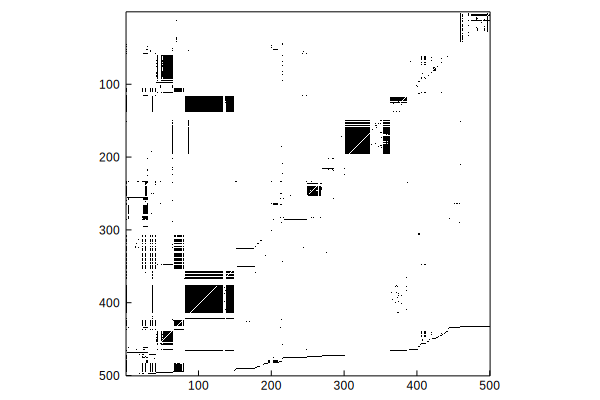

In [30]:
#Pkg.add("GR")
using Plots, GR
#plotly()
gr()
spy(A)

### Q2(4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (sparse + rank 1) to speed up the matrix-vector multiplication.

#### 1. A dense linear system solver such as LU decomposition.
LU decomposition: 
$$\mathbf{A} = \mathbf{L} \mathbf{U}, $$
where $\mathbf{L}$ is unit lower triangular and $\mathbf{U}$ is upper triangular.

As mentioned above, since $(\mathbf{P}^T - \mathbf{I}_n)$ has rank of $n-1$, and one equation is redundent, we need to replace the first equation by $\sum_{i=1}^n x_i = 1$.

In [111]:
function pagerank_lu(A::AbstractMatrix, p = 0.85)    
    
    n = size(A, 1)
    # r_i = sum(a_ij * p)
    r = vec(sum(A, 2))
    # initial the z and r1 value
    z = fill(1 / n, n)
    r1 = zeros(r)
    for i in 1:n
        if r[i] > 0
            r1[i] = p / r[i]
            z[i] = (1 - p) / n
        end
    end
    P = Diagonal(r1) * full(A) .+ z
    ImP = I - P'
    # replace the first equation to $\sum_{i=1}^n x_i = 1$
    ImP[1, :] = 1.0
    b = zeros(n)
    b[1] = 1.0
    # LU solution
    return ImP \ b
    
end

pagerank_lu (generic function with 2 methods)

In [112]:
@time x1 = pagerank_lu(A)

  0.091706 seconds (11.01 k allocations: 11.962 MiB, 15.43% gc time)


500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

#### 2. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.
Jacobi iteration: 
$$ x_i^{(t+1)} = \frac{b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(t)} - \sum_{j=i+1}^n a_{ij} x_j^{(t)}}{a_{ii}}$$


$$ \mathbf{x}^{(t+1)} = - \mathbf{D}^{-1} (\mathbf{I} - \mathbf{P}^T) \mathbf{x}^{(t)} + \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b} $$ 

$$  = \mathbf{D}^{-1} \mathbf{P}^T \mathbf{x}^{(t)} - \mathbf{D}^{-1} \mathbf{x}^{(t)} + \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b} $$

$$ = \mathbf{D}^{-1} [\mathbf{A}^T \text{diag}(\mathbf{r}^*) + \mathbf{1} \mathbf{z}^T] \mathbf{x}^{(t)} - \mathbf{D}^{-1} \mathbf{x}^{(t)} + \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b} $$ 

$$ = \mathbf{D}^{-1} \mathbf{A}^T \text{diag}(\mathbf{r}^*)\mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{1} (\mathbf{z}^T \mathbf{x}^{(t)}) - \mathbf{D}^{-1} \mathbf{x}^{(t)} + \mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{b}, $$

$$ = \mathbf{D}^{-1} \mathbf{A}^T \text{diag}(\mathbf{r}^*)\mathbf{x}^{(t)} + \mathbf{D}^{-1} \mathbf{1} (\mathbf{z}^T \mathbf{x}^{(t)}) - \mathbf{D}^{-1} \mathbf{x}^{(t)} + \mathbf{x}^{(t)}, $$

$$ = \mathbf{D}^{-1} (\mathbf{A}^T \text{diag}(\mathbf{r}^*)\mathbf{x}^{(t)} + \mathbf{z}^T \mathbf{x}^{(t)} - \mathbf{x}^{(t)}) + \mathbf{x}^{(t)}, $$

$$ = \mathbf{D}^{-1} (\mathbf{A}^T (\mathbf{r}^*.* \mathbf{x}^{(t)}) + \mathbf{z}^T \mathbf{x}^{(t)} - \mathbf{x}^{(t)}) + \mathbf{x}^{(t)}, $$

where $\mathbf{D}$ is diagonal of the matrix $\mathbf{I} - \mathbf{P}^T$.

In [100]:
function pagerank_jacobi(A::AbstractMatrix, p = 0.85)

    n = size(A, 1)
    # r_i = sum(a_ij * p)
    r = vec(sum(A, 2))
    # initial the z and r1 value
    z = fill(1 / n, n)
    r1 = zeros(r)
    for i in 1:n
        if r[i] > 0
            r1[i] = p / r[i]
            z[i] = (1 - p) / n
        end
    end
    # Get the inverse of D
    D_inv = 1 ./ (1 - diag(A) .* r1 - z)
    
    # Randomly initialize x with sum of 1
    x = rand(size(A, 1)) 
    x = x / sum(x)
    
    # Record the previous x vector
    x_prev = similar(x)
    
    # Jacobian iteration
    for i in 1:1000
        copy!(x_prev, x)
        
        # D_inv * ( A' * (r1 .* x) + z .* x - x) + x
        x .= D_inv .* ( At_mul_B(A, r1 .* x) .+ dot(z, x) .- x) .+ x
        if  vecnorm(x - x_prev) < 1e-6
            break
        end
    end
    return abs.(x / sum(x))
    
end

pagerank_jacobi (generic function with 2 methods)

In [107]:
@time x2 = pagerank_jacobi(A)

  0.000461 seconds (99 allocations: 333.656 KiB)


500-element Array{Float64,1}:
 0.0127703 
 0.00130394
 0.0040541 
 0.00398343
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00145084
 0.0014131 
 ⋮         
 0.00119591
 0.00149246
 0.00119591
 0.0034595 
 0.00211011
 0.00119591
 0.00119591
 0.00849366
 0.00119591
 0.00149105
 0.00119591
 0.00119591

#### 3. A dense eigen-solver.
We aim to find the eigenvector of the matrix $\mathbf{P}$ with eigenvalue 1:
$$ \mathbf{x}^T \mathbf{P} = \mathbf{x}^T $$

In [59]:
function pagerank_eigen(A, p = 0.85)

    n = size(A, 1)
    # r_i = sum(a_ij * p)
    r = vec(sum(A, 2))
    # initial the z and r1 value
    z = fill(1 / n, n)
    r1 = zeros(r)
    for i in 1:n
        if r[i] > 0
            r1[i] = p / r[i]
            z[i] = (1 - p) / n
        end
    end
    P = Diagonal(r1) * full(A) .+ z
    efP = eigfact!(P')
    pr = real(efP[:vectors][:, 1])   
    return abs.(pr / sum(pr))
    
end

pagerank_eigen (generic function with 2 methods)

In [60]:
x3 = pagerank_eigen(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

#### 4. A simple iterative eigen-solver such as the power method.

By choosing a random vector $\mathbf{x}^{(0)}$ with sum of 1, the pagerank can be computed by iteratively multiplication of $\mathbf{P}^T$, i.e., 
$$ \mathbf{x}^{(t+1)} = \mathbf{P}^T \mathbf{x}^{(t)} $$

In [121]:
function pagerank_power(A, p = 0.85)

    n = size(A, 1)
    # r_i = sum(a_ij * p)
    r = vec(sum(A, 2))
    # initial the z and r1 value
    z = fill(1 / n, n)
    r1 = zeros(r)
    for i in 1:n
        if r[i] > 0
            r1[i] = p / r[i]
            z[i] = (1 - p) / n
        end
    end
    # Initialize the x0 with the sum of 1
    x = rand(size(A, 1))
    x = x / sum(x)
    
    x_prev = similar(x)

    for iter in 1:1000
        copy!(x_prev, x)
        
        # x = A' * (x .* r1) + dot(x, z)
        x .= At_mul_B(A, x .* r1) + dot(x, z)

        if vecnorm(x - x_prev) < 1e-6
            break
        end
    end
    return abs.(x / sum(x))
end
    

pagerank_power (generic function with 2 methods)

In [122]:
x4 = pagerank_power(A)

500-element Array{Float64,1}:
 0.0127702 
 0.00130394
 0.00405408
 0.00398341
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00145084
 0.0014131 
 ⋮         
 0.00119591
 0.00149247
 0.00119591
 0.0034595 
 0.00211011
 0.00119591
 0.00119591
 0.00849366
 0.00119591
 0.00149105
 0.00119591
 0.00119591

### Q2(5)

List the top 20 ranked URLs you found.

In [113]:
top20 = sortperm(x1, rev = true)[1:20]
[collect(1:20) x1[top20] U[top20]]

20×3 Array{Any,2}:
  1  …  "http://schema.org"                                                     
  2     "http://www"                                                            
  3     "http://www.ucla.edu"                                                   
  4     "http://www.directory.ucla.edu"                                         
  5     "http://www.universityofcalifornia.edu"                                 
  6  …  "http://schema.org/CreativeWork"                                        
  7     "http://schema.org/Text"                                                
  8     "http://giveto.ucla.edu"                                                
  9     "http://www.registrar.ucla.edu/calendar"                                
 10     "http://www.uclalumni.net"                                              
 11  …  "http://www.magazine.ucla.edu/depts/lifesigns/honoring-adolescence"     
 12     "http://www.magazine.ucla.edu/depts/lifesigns/breaking-the-bad"         
 13     "

In [108]:
top20 = sortperm(x2, rev = true)[1:20]
[collect(1:20) x2[top20] U[top20]]

20×3 Array{Any,2}:
  1  …  "http://schema.org"                                                                     
  2     "http://www"                                                                            
  3     "http://www.ucla.edu"                                                                   
  4     "http://www.directory.ucla.edu"                                                         
  5     "http://www.universityofcalifornia.edu"                                                 
  6  …  "http://schema.org/CreativeWork"                                                        
  7     "http://schema.org/Text"                                                                
  8     "http://giveto.ucla.edu"                                                                
  9     "http://www.registrar.ucla.edu/calendar"                                                
 10     "http://www.uclalumni.net"                                                              
 11  …  "ht

In [109]:
top20 = sortperm(x3, rev = true)[1:20]
[collect(1:20) x3[top20] U[top20]]

20×3 Array{Any,2}:
  1  …  "http://schema.org"                                                                     
  2     "http://www"                                                                            
  3     "http://www.ucla.edu"                                                                   
  4     "http://www.directory.ucla.edu"                                                         
  5     "http://www.universityofcalifornia.edu"                                                 
  6  …  "http://schema.org/CreativeWork"                                                        
  7     "http://schema.org/Text"                                                                
  8     "http://giveto.ucla.edu"                                                                
  9     "http://www.registrar.ucla.edu/calendar"                                                
 10     "http://www.uclalumni.net"                                                              
 11  …  "ht

In [123]:
top20 = sortperm(x4, rev = true)[1:20]
[collect(1:20) x4[top20] U[top20]]

20×3 Array{Any,2}:
  1  …  "http://schema.org"                                                                     
  2     "http://www"                                                                            
  3     "http://www.ucla.edu"                                                                   
  4     "http://www.directory.ucla.edu"                                                         
  5     "http://www.universityofcalifornia.edu"                                                 
  6  …  "http://schema.org/CreativeWork"                                                        
  7     "http://schema.org/Text"                                                                
  8     "http://giveto.ucla.edu"                                                                
  9     "http://www.registrar.ucla.edu/calendar"                                                
 10     "http://www.uclalumni.net"                                                              
 11  …  "ht

### Q2(6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.

#### Q2(6) Answer 

We first benchmark all these four methods.

In [98]:
using BenchmarkTools
@benchmark pagerank_lu(A)

BenchmarkTools.Trial: 
  memory estimate:  11.47 MiB
  allocs estimate:  30
  --------------
  minimum time:     5.235 ms (0.00% GC)
  median time:      7.396 ms (0.00% GC)
  mean time:        7.338 ms (14.99% GC)
  maximum time:     15.017 ms (16.31% GC)
  --------------
  samples:          681
  evals/sample:     1

In [102]:
@benchmark pagerank_jacobi(A)

BenchmarkTools.Trial: 
  memory estimate:  284.70 KiB
  allocs estimate:  82
  --------------
  minimum time:     312.256 μs (0.00% GC)
  median time:      385.390 μs (0.00% GC)
  mean time:        471.238 μs (13.52% GC)
  maximum time:     6.406 ms (91.26% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [103]:
@benchmark pagerank_eigen(A)

BenchmarkTools.Trial: 
  memory estimate:  13.55 MiB
  allocs estimate:  510
  --------------
  minimum time:     337.990 ms (0.00% GC)
  median time:      389.671 ms (0.82% GC)
  mean time:        390.825 ms (0.57% GC)
  maximum time:     462.481 ms (0.91% GC)
  --------------
  samples:          13
  evals/sample:     1

In [124]:
@benchmark pagerank_power(A)

BenchmarkTools.Trial: 
  memory estimate:  325.17 KiB
  allocs estimate:  87
  --------------
  minimum time:     303.318 μs (0.00% GC)
  median time:      373.808 μs (0.00% GC)
  mean time:        480.806 μs (16.78% GC)
  maximum time:     11.082 ms (89.56% GC)
  --------------
  samples:          10000
  evals/sample:     1

#### Remarks
As we can see, Jacobi and Power methods (which are both iterative methods) clearly demonstrate the advanatge onver LU decomposition and eigen method in terms of running time, which is critical to successfully handle the PageRank problem with the Internet scale. Another advantage of the power method is it can be implemented in thousands of distributed servers to obtain the good performance.

In [125]:
versioninfo()

Julia Version 0.6.2
Commit d386e40c17 (2017-12-13 18:08 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, haswell)
